### Plot best parameters for individual mice

In [17]:
""" 
IMPORTS
"""
import json
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from glm_hmm_utils import load_animal_list
from post_processing_utils import load_data, load_glmhmm_data, load_cv_arr, \
    create_cv_frame_for_plotting, get_file_name_for_best_model_fold, \
    partition_data_by_session, create_violation_mask, get_marginal_posterior


In [18]:
""" 
DIRECTORIES 
"""
prior_sigma = 2
transition_alpha = 2
num_bins = 10
Ks = [2, 3]
results_dir = '../../results/ibl_individual_fit/'

data_dir = '/home/ines/repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
data_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
processed_ibl_data_path = data_dir + "data_by_bin" + str(num_bins) + "global_normalization/"


In [19]:
    animal_list = load_animal_list(processed_ibl_data_path + 'animal_list.npz')


In [20]:
len(animal_list)

49

DY_013
../../results/ibl_individual_fit/DY_013_10/GLM_HMM_K_2/fold_0/iter_9/glm_hmm_raw_parameters_itr_9.npz
../../results/ibl_individual_fit/DY_013_10/GLM_HMM_K_3/fold_0/iter_9/glm_hmm_raw_parameters_itr_9.npz
DY_012
../../results/ibl_individual_fit/DY_012_10/GLM_HMM_K_2/fold_0/iter_9/glm_hmm_raw_parameters_itr_9.npz
../../results/ibl_individual_fit/DY_012_10/GLM_HMM_K_3/fold_0/iter_9/glm_hmm_raw_parameters_itr_9.npz


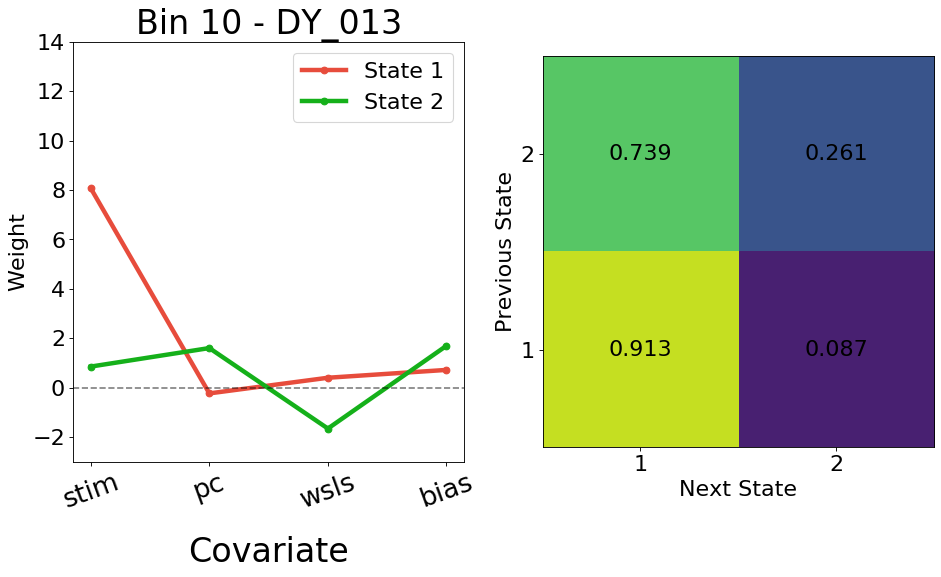

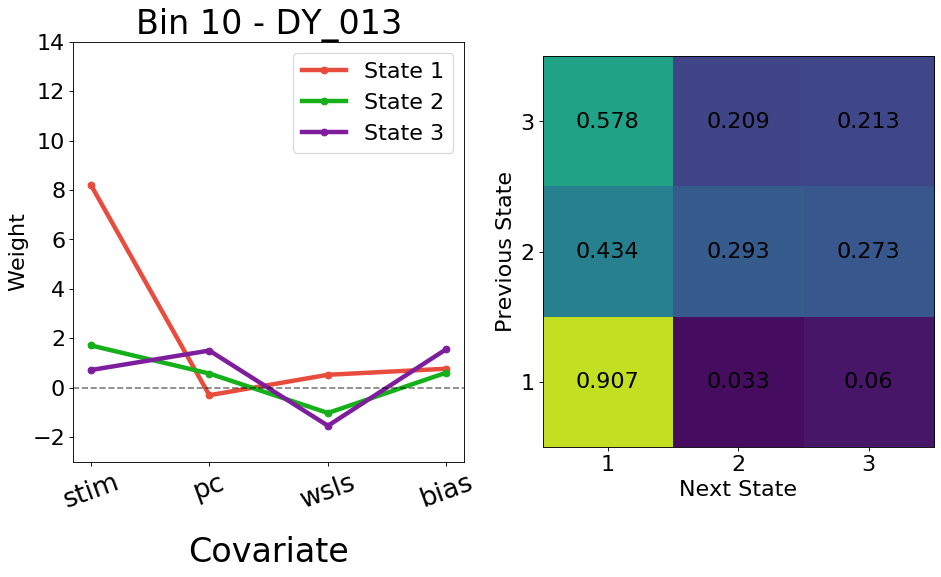

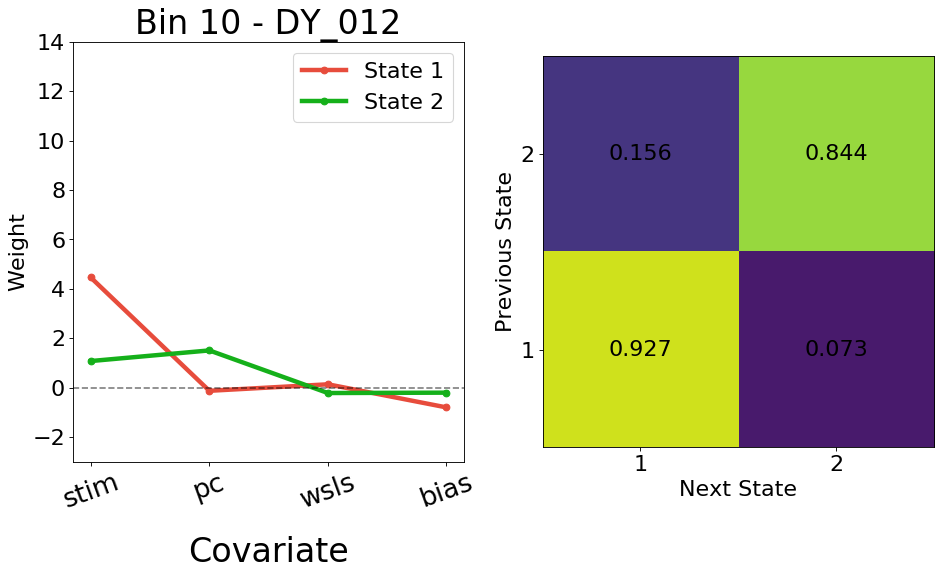

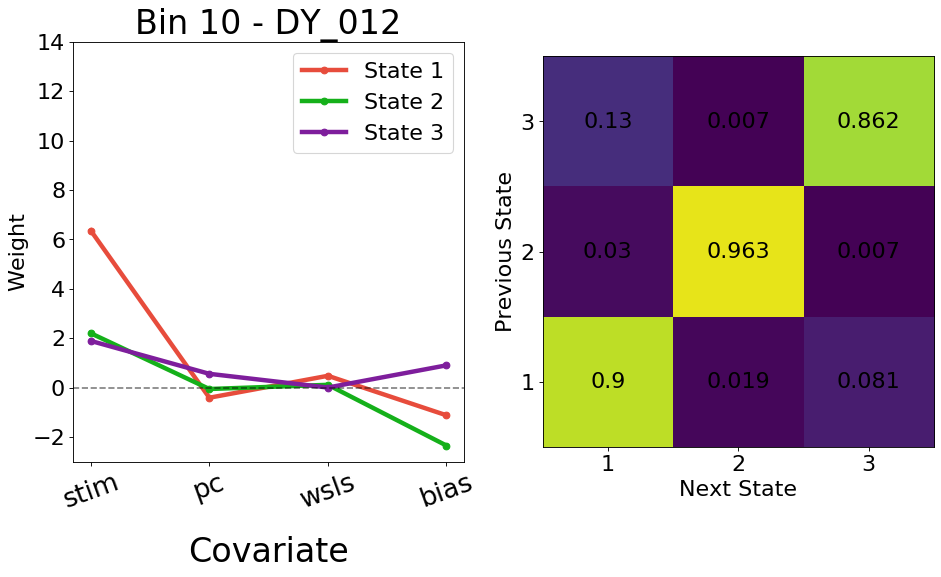

In [21]:
bins_interest = [0, 5, 9]
bins_interest = [9]
for b, bin in enumerate(bins_interest):

    labels_for_plot = ['stim', 'pc', 'wsls', 'bias']

    animal_list = load_animal_list(processed_ibl_data_path + 'animal_list.npz')
    animal_list = ['DY_013', 'DY_012']
    for animal in animal_list:
        print(animal)
        results_this_animal_dir = results_dir + animal + '_' + str(bin+1) 

        cv_file = results_this_animal_dir + '/GLMHMM/' + "/cvbt_folds_model.npz"
        cvbt_folds_model = load_cv_arr(cv_file)

        for K in Ks:
            save_dir = results_dir + 'params_all_animals/K_' + str(K) + '/'
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            with open(results_this_animal_dir +
                      "/best_init_cvbt_dict.json", 'r') as f:
               best_init_cvbt_dict = json.load(f)

            # Get the file name corresponding to the best
            # initialization for given K value
            fits_file = results_this_animal_dir 
            raw_file = get_file_name_for_best_model_fold(
                cvbt_folds_model, K, fits_file, best_init_cvbt_dict)
            print(raw_file)
            hmm_params, lls = load_glmhmm_data(raw_file)

            # Save parameters for initializing individual fits
            weight_vectors = hmm_params[2]
            log_transition_matrix = hmm_params[1][0]
            init_state_dist = hmm_params[0][0]

            # Plot these too:
            cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306"]
            fig = plt.figure(figsize=(5 * 5, 7),
                             dpi=80,
                             facecolor='w',
                             edgecolor='k')
            plt.subplots_adjust(left=0.05,
                                bottom=0.1,
                                right=0.95,
                                top=0.85,
                                wspace=0.2,
                                hspace=0.1)
            plt.subplot(1, 4, 1)
            M = weight_vectors.shape[2] - 1
            for k in range(K):
                plt.plot(range(M + 1),
                         -weight_vectors[k][0],
                         marker='o',
                         label='State ' + str(k + 1),
                         color=cols[k],
                         lw=4)
            plt.xticks(list(range(0, len(labels_for_plot))),
                       labels_for_plot,
                       rotation='20',
                       fontsize=24)
            plt.yticks(fontsize=20)
            plt.legend(fontsize=20)
            plt.axhline(y=0, color="k", alpha=0.5, ls="--")
            plt.ylim((-3, 14))
            plt.ylabel("Weight", fontsize=20)
            plt.xlabel("Covariate", fontsize=30, labelpad=20)
            plt.title("GLM Weights: Choice = R", fontsize=20)
            plt.title("Bin " + str(bin+1) +' - ' + animal, fontsize=30)

            plt.subplot(1, 4, 2)
            transition_matrix = np.exp(log_transition_matrix)
            plt.imshow(transition_matrix, vmin=0, vmax=1)
            for i in range(transition_matrix.shape[0]):
                for j in range(transition_matrix.shape[1]):
                    text = plt.text(j,
                                    i,
                                    np.around(transition_matrix[i, j],
                                              decimals=3),
                                    ha="center",
                                    va="center",
                                    color="k",
                                    fontsize=20)
            plt.ylabel("Previous State", fontsize=20)
            plt.xlabel("Next State", fontsize=20)
            plt.xlim(-0.5, K - 0.5)
            plt.ylim(-0.5, K - 0.5)
            plt.xticks(range(0, K), ('1', '2', '3', '4', '4', '5', '6', '7',
                                     '8', '9', '10')[:K],
                       fontsize=20)
            plt.yticks(range(0, K), ('1', '2', '3', '4', '4', '5', '6', '7',
                                     '8', '9', '10')[:K],
                       fontsize=20)
            """
            plt.subplot(1, 4, 3)
            cols = [
                "#7e1e9c", "#0343df", "#15b01a", "#bf77f6", "#95d0fc",
                "#96f97b"
            ]
            cv_file = results_this_animal_dir + "/cvbt_folds_model.npz"
            data_for_plotting_df, loc_best, best_val, \
            glm_lapse_model = create_cv_frame_for_plotting(
                cv_file)
            cv_file_train = results_this_animal_dir + "/cvbt_train_folds_model.npz"
            train_data_for_plotting_df, train_loc_best, \
            train_best_val, train_glm_lapse_model = \
                create_cv_frame_for_plotting(
                    cv_file_train)

            glm_lapse_model_cvbt_means = np.mean(glm_lapse_model, axis=1)
            train_glm_lapse_model_cvbt_means = np.mean(train_glm_lapse_model,
                                                       axis=1)
            g = sns.lineplot(data_for_plotting_df['model'],
                             data_for_plotting_df['cv_bit_trial'],
                             err_style="bars",
                             mew=0,
                             color=cols[0],
                             marker='o',
                             ci=68,
                             label="test",
                             alpha=1,
                             lw=4)
            sns.lineplot(train_data_for_plotting_df['model'],
                         train_data_for_plotting_df['cv_bit_trial'],
                         err_style="bars",
                         mew=0,
                         color=cols[1],
                         marker='o',
                         ci=68,
                         label="train",
                         alpha=1,
                         lw=4)
            plt.scatter(loc_best, best_val, s=400, color='black', marker="*")
            plt.xlabel("Model", fontsize=30)
            plt.ylabel("Normalized LL", fontsize=30)
            plt.xticks([0, 1, 2, 3, 4],
                       ['1 State', '2 State', '3 State', '4 State', '5 State'],
                       rotation=45,
                       fontsize=24)
            plt.yticks(fontsize=15)
            plt.axhline(y=glm_lapse_model_cvbt_means[2],
                        color=cols[2],
                        label="Lapse (test)",
                        alpha=0.9,
                        lw=4)
            plt.legend(loc='upper right', fontsize=30)
            plt.tick_params(axis='y')
            plt.yticks([0.2, 0.3, 0.4, 0.5], fontsize=30)
            plt.ylim((0.2, 0.55))
            plt.title("Model Comparison", fontsize=40)

            plt.subplot(1, 4, 4)
            # get state occupancies:
            inpt, y, session = load_data(data_dir + animal + '_processed.npz')
            inpt = np.hstack((inpt, np.ones((len(inpt), 1))))
            # Identify violations for exclusion:
            violation_idx = np.where(y == -1)[0]
            nonviolation_idx, mask = create_violation_mask(
                violation_idx, inpt.shape[0])
            y[np.where(y == -1), :] = 1  # due to mask, doesn't matter what
            # we set y to at violation idx
            inputs, datas, masks = partition_data_by_session(
                inpt, y, mask, session)
            posterior_probs = get_marginal_posterior(inputs, datas, masks,
                                                     hmm_params, K, range(K))
            states_max_posterior = np.argmax(posterior_probs, axis=1)
            plt.hist(states_max_posterior)
            plt.ylabel("# trials", fontsize=30)
            plt.xlabel("State", fontsize=30)
            plt.xticks(range(K), range(1, K + 1), fontsize=30)
            plt.yticks(fontsize=30)
            plt.title("State occuupancies", fontsize=40)

            fig.suptitle(animal, fontsize=40)
            fig.savefig(save_dir + animal + '.png')
            """